## **Partie I :  Prise en main avec le processus d'apprentissage avec le framework Pytorch**

___

## **Instruction 1 : importation des librariries**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

## **Question 1 : créer une BD synthétique et tracer la courbe (1000 paires données X,Y)**

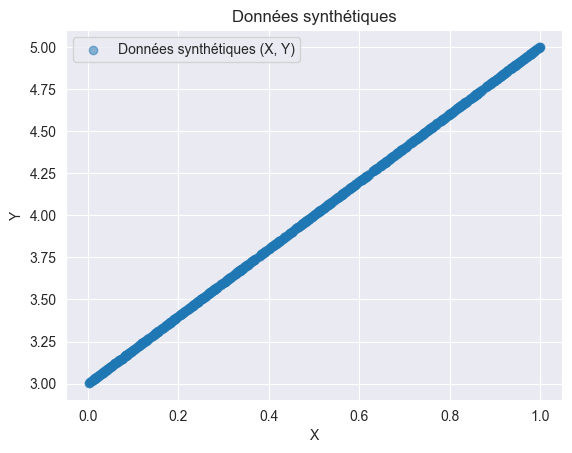

In [3]:
a = 2
b = 3
X = np.random.rand(1000)
Y = a * X + b

plt.scatter(X, Y, alpha=0.5, label="Données synthétiques (X, Y)")
plt.title("Données synthétiques")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

## **Question 2: convertir les données d'entrée (X) en tenseurs**

In [4]:
X_data = X.reshape(-1,1)
Y_target = Y.reshape(-1,1)
X_tensor = torch.FloatTensor(X_data)
Y_tensor = torch.FloatTensor(Y_target)

print("Dimensions de X_tensor :", X_tensor.shape)
print("Dimensions de Y_tensor :", Y_tensor.shape)

Dimensions de X_tensor : torch.Size([1000, 1])
Dimensions de Y_tensor : torch.Size([1000, 1])


## **Instruction 2 : définir l'architecture de votre modèle**

In [5]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

##  **Question 3 : intialiser le modèle et définir la donction de perte et optimiseur**

In [6]:
model = Model()

criterion = nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

## **Question 4 : compléter la boucle d'entraînement et entraîner votre modèle**

Époque 10/100, Perte : 10.4360


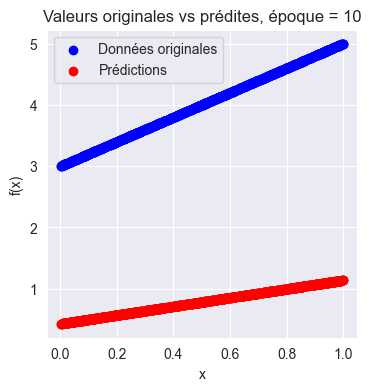

Époque 20/100, Perte : 6.2655


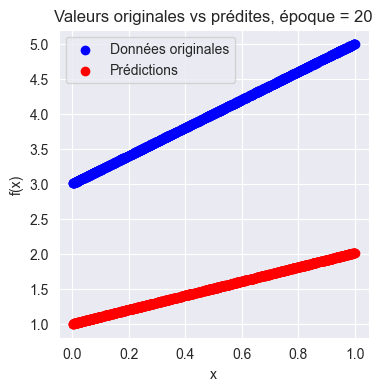

Époque 30/100, Perte : 3.7617


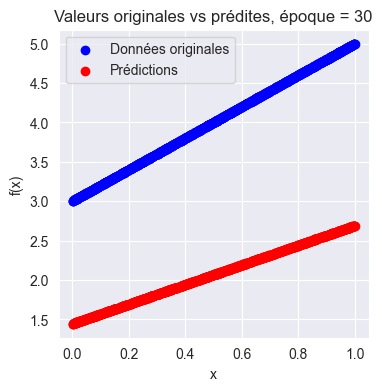

Époque 40/100, Perte : 2.2585


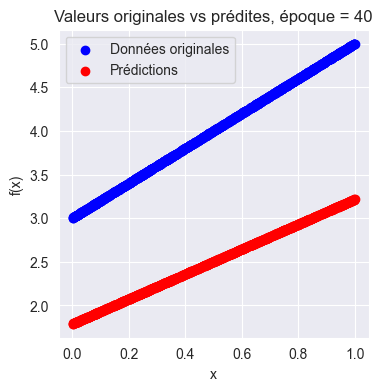

Époque 50/100, Perte : 1.3560


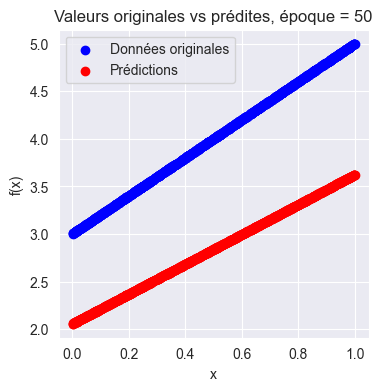

Époque 60/100, Perte : 0.8142


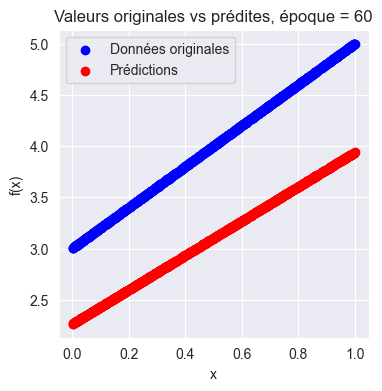

Époque 70/100, Perte : 0.4889


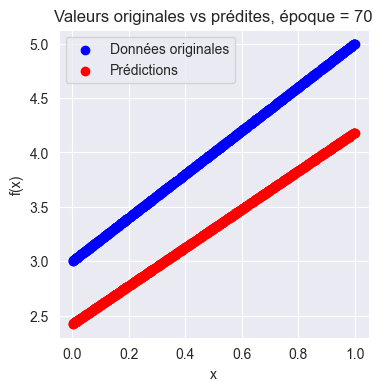

Époque 80/100, Perte : 0.2936


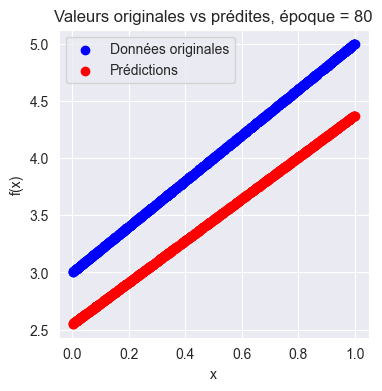

Époque 90/100, Perte : 0.1763


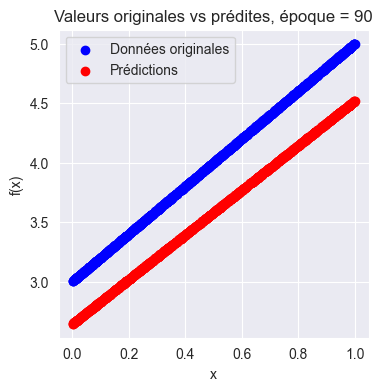

Époque 100/100, Perte : 0.1059


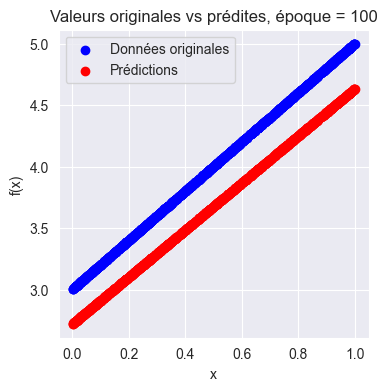

In [7]:
# Paramètres pour l'entraînement
epochs = 100  # Nombre d'itérations
losses = []   # Liste pour suivre l'évolution de la perte

# Boucle d'entraînement
for epoch in range(epochs):
    # 1. Réinitialiser les gradients
    optimizer.zero_grad()

    # 2. Passer les données dans le modèle (forward pass)
    predictions = model(X_tensor)

    # 3. Calculer la perte
    loss = criterion(predictions, Y_tensor)
    losses.append(loss.item())

    # 4. Calculer les gradients (backward pass)
    loss.backward()

    # 5. Mettre à jour les poids
    optimizer.step()

    # Afficher la perte toutes les 10 époques
    if (epoch + 1) % 10 == 0:
        print(f"Époque {epoch + 1}/{epochs}, Perte : {loss.item():.4f}")
        plt.figure(figsize=(4, 4))
        plt.scatter(X, Y, color='blue', label='Données originales')
        plt.scatter(X, predictions.detach().numpy(), color='red', label='Prédictions')
        plt.xlabel('x')
        plt.ylabel('f(x)')
        plt.title(f'Valeurs originales vs prédites, époque = {epoch+1}')
        plt.legend()
        plt.show()

## **Question 5 : Afficher les paramètres (poids) appris et tracer les résultats de votre modèle**

In [8]:
a = model.linear.weight.item()
b = model.linear.bias.item()

print(f"Paramètres appris par le modèle : a = {a:.4f}, b = {b:.4f}")

Paramètres appris par le modèle : a = 1.9168, b = 2.7245


# **Partie II : Modèles Machine Learning --> prédiction de prix de maisons (Suite TP1)**

## **Instruction 3 : importer les librairies**

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## **Instruction 4 : charger les données et fonction de prétraitement (prix maisons)**

In [10]:
housing = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
housing_test = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")
#housing=housing.reindex(np.random.permutation(housing.index))
housing=housing.sample(frac=1.)

def preprocess_features(california_housing_dataframe):
    processed_features = california_housing_dataframe.copy()
    selected_features = ["latitude","longitude","housing_median_age","total_rooms",
     "total_bedrooms","population","households","median_income","rooms_per_person"]
   # Create a synthetic feature.
    processed_features["rooms_per_person"] = california_housing_dataframe["total_rooms"] / california_housing_dataframe["population"]
    return processed_features[selected_features]

def preprocess_targets(california_housing_dataframe):
    california_housing_dataframe["median_house_value"] = california_housing_dataframe["median_house_value"] / 1000.0
    return california_housing_dataframe["median_house_value"]


df_processed_features = preprocess_features(housing)
df_processed_features["median_house_value"] = preprocess_targets(housing)

df_processed_features_test = preprocess_features(housing_test)
df_processed_features_test["median_house_value"] = preprocess_targets(housing_test)


X_train = df_processed_features.drop("median_house_value", axis=1)
y_train = df_processed_features["median_house_value"]
X_test = df_processed_features_test.drop("median_house_value", axis=1)
y_test = df_processed_features_test["median_house_value"]


## **Instruction 5 : normaliser les données**

In [11]:
scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

y_train_transformed = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_transformed = y_scaler.transform(y_test.values.reshape(-1, 1))

## **Instruction 6 : définir les métriques d'évaluation : MAE, MAPE et R2**

In [12]:
def custom_MAE(y_true, y_pred, scaler):
    # Reshape if needed
    if len(y_true.shape) == 1:
        y_true = y_true.reshape(-1, 1)
    if len(y_pred.shape) == 1:
        y_pred = y_pred.reshape(-1, 1)

    y_true_unscaled = scaler.inverse_transform(y_true)
    y_pred_unscaled = scaler.inverse_transform(y_pred)
    return np.mean(np.abs(y_true_unscaled - y_pred_unscaled))


def custom_MAPE(y_true, y_pred, scaler, epsilon=1e-7):
    # Reshape if needed
    if len(y_true.shape) == 1:
        y_true = y_true.reshape(-1, 1)
    if len(y_pred.shape) == 1:
        y_pred = y_pred.reshape(-1, 1)

    y_true_unscaled = scaler.inverse_transform(y_true)
    y_pred_unscaled = scaler.inverse_transform(y_pred)
    diff = np.abs(y_true_unscaled - y_pred_unscaled)
    denom = np.maximum(np.abs(y_true_unscaled), epsilon)
    return np.mean(diff / denom)

def custom_r2_score(y_true, y_pred, scaler):
    # Reshape if needed
    if len(y_true.shape) == 1:
        y_true = y_true.reshape(-1, 1)
    if len(y_pred.shape) == 1:
        y_pred = y_pred.reshape(-1, 1)

    y_true_unscaled = scaler.inverse_transform(y_true)
    y_pred_unscaled = scaler.inverse_transform(y_pred)
    r2 = r2_score(y_true_unscaled, y_pred_unscaled)
    return r2

## **Question 6 : définir un modèle de régression linéaire pour vos données**



In [13]:
lr_model = LinearRegression()
lr_model.fit(X_train_transformed, y_train_transformed)

LinearRegression()

## **Instruction 7 : Evaluer votre modèle avec les données d'entraînement et de test**

In [14]:
# Make predictions on train and test sets
train_predictions = lr_model.predict(X_train_transformed).reshape(-1, 1)
test_predictions = lr_model.predict(X_test_transformed).reshape(-1, 1)

# Calculate metrics using our custom functions
train_mae = custom_MAE(y_train_transformed, train_predictions, y_scaler)
train_mape = custom_MAPE(y_train_transformed, train_predictions, y_scaler)
train_r2 = custom_r2_score(y_train_transformed, train_predictions, y_scaler)

test_mae = custom_MAE(y_test_transformed, test_predictions, y_scaler)
test_mape = custom_MAPE(y_test_transformed, test_predictions, y_scaler)
test_r2 = custom_r2_score(y_test_transformed, test_predictions, y_scaler)

# Print results
print("Training Set Metrics:")
print(f"MAE: {train_mae:.4f}")
print(f"MAPE: {train_mape:.4f}")
print(f"R2 Score: {train_r2:.4f}")

print("\nTest Set Metrics:")
print(f"MAE: {test_mae:.4f}")
print(f"MAPE: {test_mape:.4f}")
print(f"R2 Score: {test_r2:.4f}")

Training Set Metrics:
MAE: 50.2704
MAPE: 0.3005
R2 Score: 0.6489

Test Set Metrics:
MAE: 49.7491
MAPE: 0.2941
R2 Score: 0.6266


## **Instruction 8 : fonction d'affichage de plot Prix réels/Prix prédits**

In [15]:
def plot_model_predictions(model, X_test_transformed, y_test):
    # Faire les prédictions
    test_predictions = model.predict(X_test_transformed).reshape(-1, 1)

    # Créer un DataFrame pour la visualisation
    result = pd.DataFrame({
        'house': list(range(100)),
        'Real Values': y_test.values[:100].reshape(-1),
        'Predictions': y_scaler.inverse_transform(test_predictions)[:100].reshape(-1)
    })

    # Créer le graphique avec seaborn
    plt.figure(figsize=(15, 7))
    sns.lineplot(data=result, x='house', y='Real Values', marker='o', label='Real Values')
    sns.lineplot(data=result, x='house', y='Predictions', marker='o', label='Predictions')

    plt.title('Prédictions vs Valeurs Réelles')
    plt.xlabel('Index de Maison')
    plt.ylabel('Valeur de Maison')
    plt.legend(title='Valeurs')
    plt.show()

## **Question 8: aficher le plot de prix réels/ prix prédits**

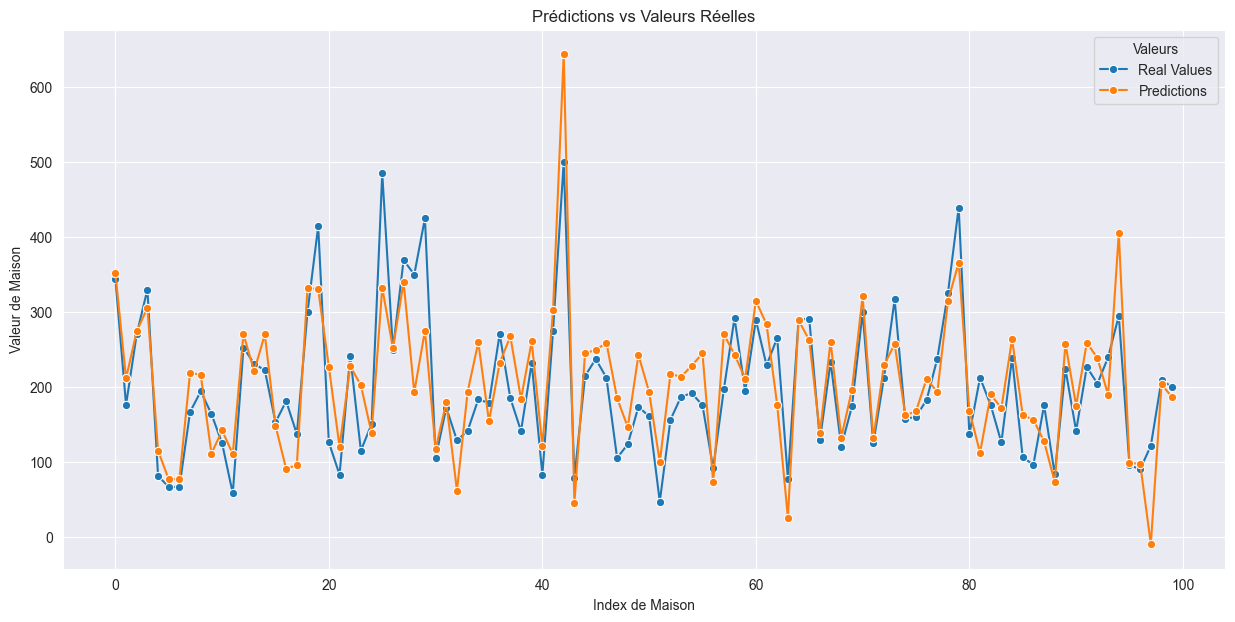

In [16]:
plot_model_predictions(lr_model, X_test_transformed, y_test)

## **Question 9 : définir et entraîner un modèle de type arbre de décision pour vos données**

In [17]:
# Étape 1 : Initialisation du modèle d'arbre de décision
tree_model = DecisionTreeRegressor(random_state=42)

# Étape 2 : Entraîner le modèle avec les données d'entraînement
tree_model.fit(X_train_transformed, y_train_transformed)

DecisionTreeRegressor(random_state=42)

## **Question 10 : Evaluer le modèle "Arbre de décision" avec données d'entrainement et de test**

In [18]:
# Initialisation du modèle d'arbre de décision avec des paramètres spécifiques
tree_model_tuned = DecisionTreeRegressor(max_depth=10, min_samples_leaf=4, random_state=42)

# Entraîner le modèle avec les données d'entraînement
tree_model_tuned.fit(X_train_transformed, y_train_transformed)

# Faire les prédictions
train_predictions_tree_tuned = tree_model_tuned.predict(X_train_transformed).reshape(-1, 1)
test_predictions_tree_tuned = tree_model_tuned.predict(X_test_transformed).reshape(-1, 1)

# Calcul des métriques
train_mae_tree_tuned = custom_MAE(y_train_transformed, train_predictions_tree_tuned, y_scaler)
train_mape_tree_tuned = custom_MAPE(y_train_transformed, train_predictions_tree_tuned, y_scaler)
train_r2_tree_tuned = custom_r2_score(y_train_transformed, train_predictions_tree_tuned, y_scaler)

test_mae_tree_tuned = custom_MAE(y_test_transformed, test_predictions_tree_tuned, y_scaler)
test_mape_tree_tuned = custom_MAPE(y_test_transformed, test_predictions_tree_tuned, y_scaler)
test_r2_tree_tuned = custom_r2_score(y_test_transformed, test_predictions_tree_tuned, y_scaler)

# Afficher les résultats
print("Arbre de Décision (Tuned) - Performance sur l'ensemble d'entraînement :")
print(f"MAE : {train_mae_tree_tuned:.4f}")
print(f"MAPE : {train_mape_tree_tuned:.4%}")
print(f"R² : {train_r2_tree_tuned:.4f}")

print("\nArbre de Décision (Tuned) - Performance sur l'ensemble de test :")
print(f"MAE : {test_mae_tree_tuned:.4f}")
print(f"MAPE : {test_mape_tree_tuned:.4%}")
print(f"R² : {test_r2_tree_tuned:.4f}")

Arbre de Décision (Tuned) - Performance sur l'ensemble d'entraînement :
MAE : 30.9178
MAPE : 17.1547%
R² : 0.8409

Arbre de Décision (Tuned) - Performance sur l'ensemble de test :
MAE : 39.5293
MAPE : 21.2810%
R² : 0.7158


## **Question 11: aficher le plot de prix réels/ prix prédits**

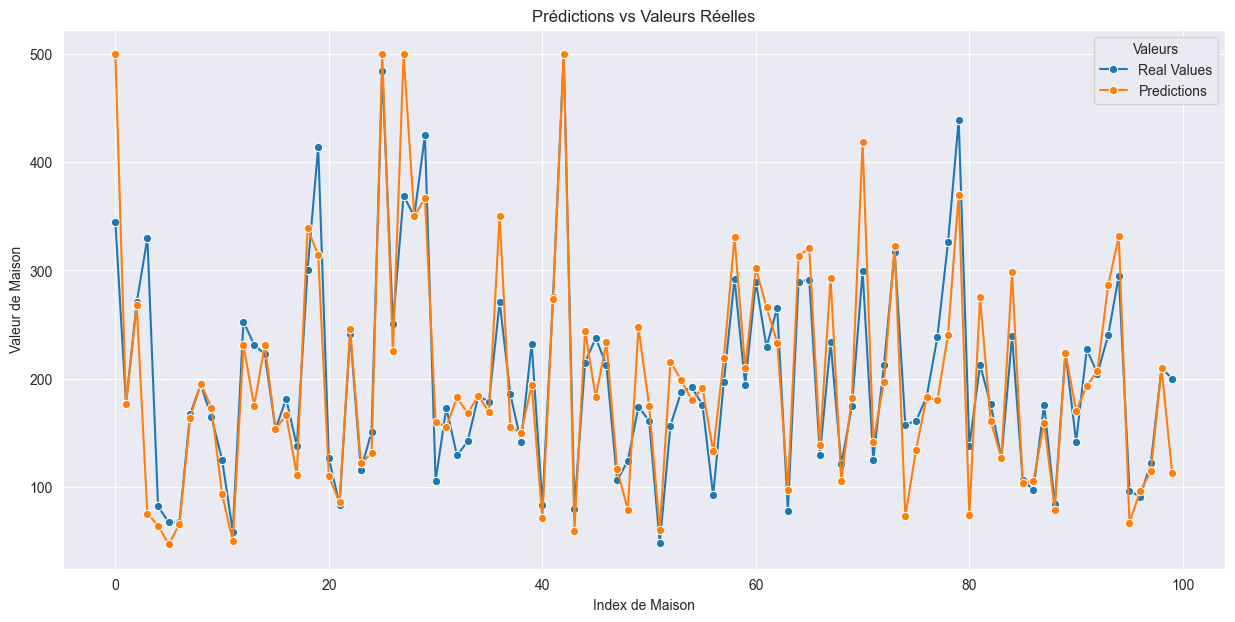

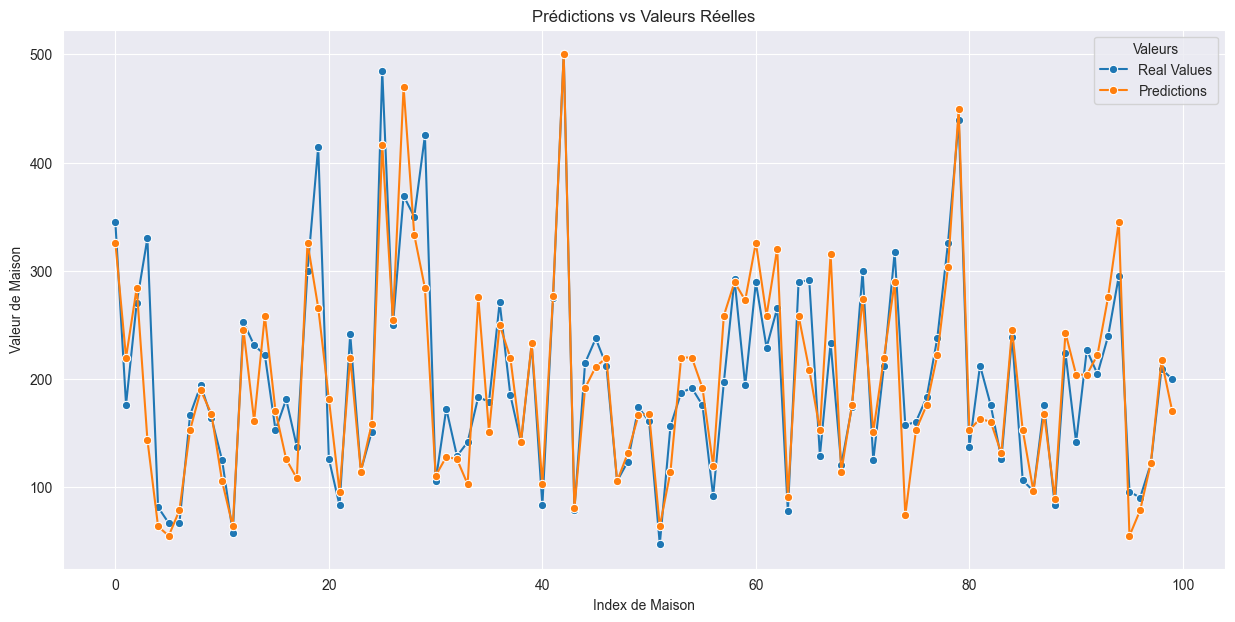

In [19]:
# Plot des prédictions pour l'arbre initial
plot_model_predictions(tree_model, X_test_transformed, y_test)

# Plot des prédictions pour l'arbre avec hyperparamètres ajustés
plot_model_predictions(tree_model_tuned, X_test_transformed, y_test)

## **Question 12 : définir/entraîner un arbre de décision personnalisé (voire param. de l'énoncé)**


In [20]:
# Initialisation du modèle d'arbre de décision avec des paramètres spécifiques
tree_model_tuned = DecisionTreeRegressor(max_depth=10, min_samples_leaf=4, random_state=42)

# Entraîner le modèle avec les données d'entraînement
tree_model_tuned.fit(X_train_transformed, y_train_transformed)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=4, random_state=42)

## **Question 13 : Evaluer l'Arbre de décision personalisé avec données d'entrainement et de test**

In [21]:
# Faire les prédictions
train_predictions_tree_tuned = tree_model_tuned.predict(X_train_transformed).reshape(-1, 1)
test_predictions_tree_tuned = tree_model_tuned.predict(X_test_transformed).reshape(-1, 1)

# Calcul des métriques
train_mae_tree_tuned = custom_MAE(y_train_transformed, train_predictions_tree_tuned, y_scaler)
train_mape_tree_tuned = custom_MAPE(y_train_transformed, train_predictions_tree_tuned, y_scaler)
train_r2_tree_tuned = custom_r2_score(y_train_transformed, train_predictions_tree_tuned, y_scaler)

test_mae_tree_tuned = custom_MAE(y_test_transformed, test_predictions_tree_tuned, y_scaler)
test_mape_tree_tuned = custom_MAPE(y_test_transformed, test_predictions_tree_tuned, y_scaler)
test_r2_tree_tuned = custom_r2_score(y_test_transformed, test_predictions_tree_tuned, y_scaler)

# Afficher les résultats
print("Arbre de Décision (Tuned) - Performance sur l'ensemble d'entraînement :")
print(f"MAE : {train_mae_tree_tuned:.4f}")
print(f"MAPE : {train_mape_tree_tuned:.4%}")
print(f"R² : {train_r2_tree_tuned:.4f}")

print("\nArbre de Décision (Tuned) - Performance sur l'ensemble de test :")
print(f"MAE : {test_mae_tree_tuned:.4f}")
print(f"MAPE : {test_mape_tree_tuned:.4%}")
print(f"R² : {test_r2_tree_tuned:.4f}")

Arbre de Décision (Tuned) - Performance sur l'ensemble d'entraînement :
MAE : 30.9178
MAPE : 17.1547%
R² : 0.8409

Arbre de Décision (Tuned) - Performance sur l'ensemble de test :
MAE : 39.5293
MAPE : 21.2810%
R² : 0.7158


## **Question 14: aficher le plot de prix réels/ prix prédits**

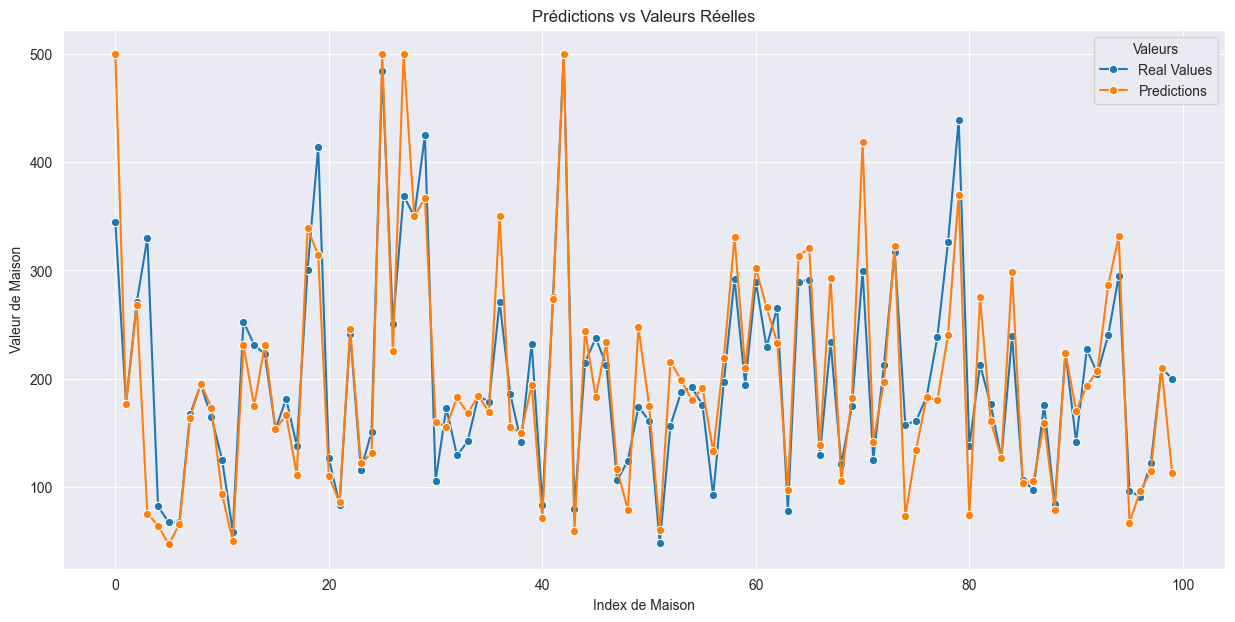

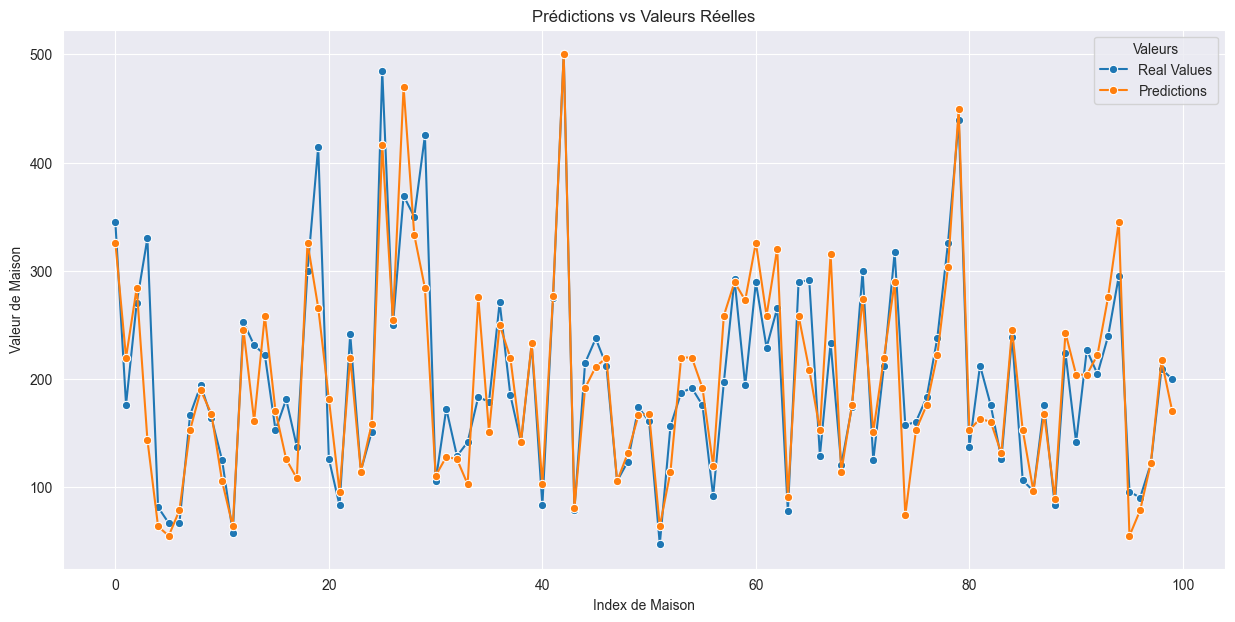

In [22]:
# Plot des prédictions pour l'arbre initial
plot_model_predictions(tree_model, X_test_transformed, y_test)

# Plot des prédictions pour l'arbre avec hyperparamètres ajustés
plot_model_predictions(tree_model_tuned, X_test_transformed, y_test)

## **Question 15 : définir et entraîner un modèle de type "Random Forest" pour vos données**

In [23]:
# Étape 1 : Initialisation du modèle Random Forest
rf_model = RandomForestRegressor(random_state=42)

# Étape 2 : Entraîner le modèle avec les données d'entraînement
rf_model.fit(X_train_transformed, y_train_transformed.ravel())  # ravel() pour éviter les warnings

RandomForestRegressor(random_state=42)

## **Question 16 : Evaluer le modèle Random Forest avec les données d'entrainement et de test**

In [24]:
# Faire des prédictions sur les ensembles d'entraînement et de test
train_predictions_rf = rf_model.predict(X_train_transformed).reshape(-1, 1)
test_predictions_rf = rf_model.predict(X_test_transformed).reshape(-1, 1)

# Calcul des métriques pour l'ensemble d'entraînement
train_mae_rf = custom_MAE(y_train_transformed, train_predictions_rf, y_scaler)
train_mape_rf = custom_MAPE(y_train_transformed, train_predictions_rf, y_scaler)
train_r2_rf = custom_r2_score(y_train_transformed, train_predictions_rf, y_scaler)

# Calcul des métriques pour l'ensemble de test
test_mae_rf = custom_MAE(y_test_transformed, test_predictions_rf, y_scaler)
test_mape_rf = custom_MAPE(y_test_transformed, test_predictions_rf, y_scaler)
test_r2_rf = custom_r2_score(y_test_transformed, test_predictions_rf, y_scaler)

# Afficher les résultats
print("Random Forest - Performance sur l'ensemble d'entraînement :")
print(f"MAE : {train_mae_rf:.4f}")
print(f"MAPE : {train_mape_rf:.4%}")
print(f"R² : {train_r2_rf:.4f}")

print("\nRandom Forest - Performance sur l'ensemble de test :")
print(f"MAE : {test_mae_rf:.4f}")
print(f"MAPE : {test_mape_rf:.4%}")
print(f"R² : {test_r2_rf:.4f}")

Random Forest - Performance sur l'ensemble d'entraînement :
MAE : 11.1526
MAPE : 6.1253%
R² : 0.9772

Random Forest - Performance sur l'ensemble de test :
MAE : 30.7727
MAPE : 16.8232%
R² : 0.8153


## **Question 17: aficher le plot de prix réels/ prix prédits**

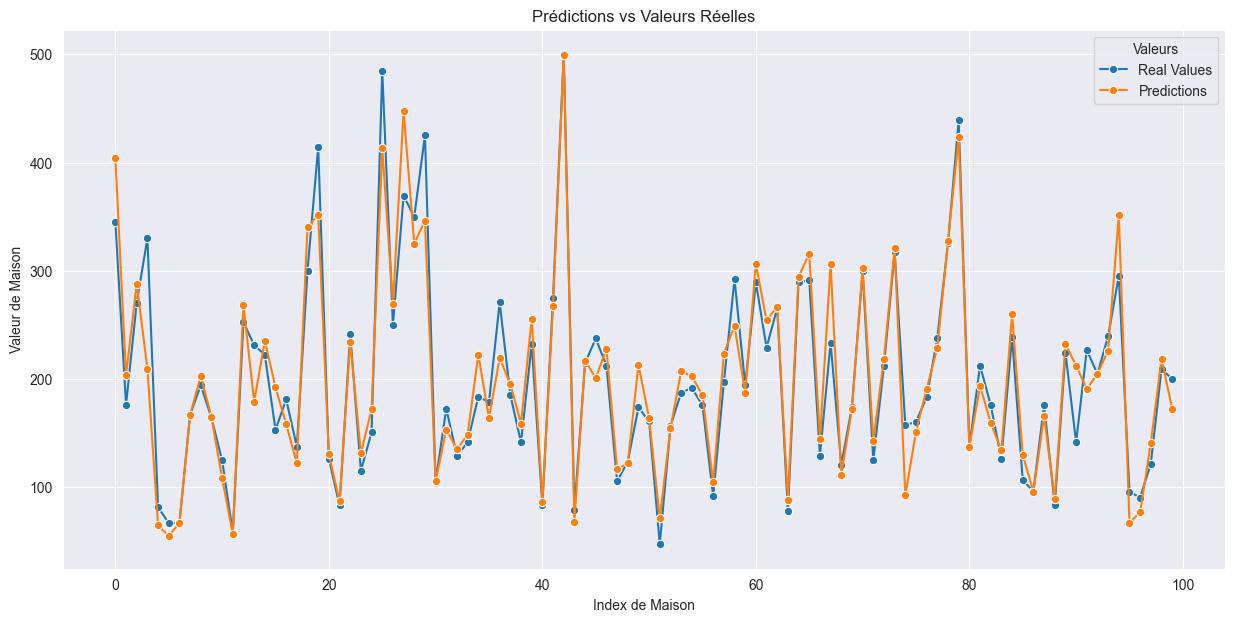

In [25]:
plot_model_predictions(rf_model, X_test_transformed, y_test)

## **Partie II :  évaluation/analyse comparative différents modèles Machine Learning avec PyCaret**

## **Instruction 12 : installation et importation des librairies**

In [26]:
# !pip install pycaret

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.regression import *

## **Instruction 13 : Défintion des données d'entrée (X)et de sortie (Y)**

In [28]:
train_data = pd.DataFrame(X_train_transformed, columns=X_train.columns)
train_data["median_house_value"]= y_train.values

In [29]:
test_data = pd.DataFrame(X_test_transformed, columns=X_test.columns)
test_data['median_house_value']=y_test.values

## **Instruction 14 : configuration du pipeline d'apprentissage avec PyCaret**

In [30]:
setup(data=train_data,target="median_house_value",session_id=123,test_data=test_data,index=False,preprocess=False)

,Description,Value
0,Session id,123
1,Target,median_house_value
2,Target type,Regression
3,Original data shape,"(20000, 10)"
4,Transformed data shape,"(20000, 10)"
5,Transformed train set shape,"(17000, 10)"
6,Transformed test set shape,"(3000, 10)"
7,Numeric features,9


## **Instruction 15 : lancer la comparaison entre plusieurs modèles ML avec PyCaret**


In [31]:
best_model = compare_models(exclude =['ransac'],sort="R2")

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,19:47:53
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,30.9465,2126.0080,46.0970,0.8416,0.2272,0.1735,0.1350
rf,Random Forest Regressor,30.4461,2228.9426,47.1990,0.8340,0.2244,0.1680,1.0310
et,Extra Trees Regressor,33.5347,2564.1180,50.6260,0.8089,0.2382,0.1860,0.4080
gbr,Gradient Boosting Regressor,36.7443,2797.8213,52.8753,0.7917,0.2633,0.2096,0.3690
knn,K Neighbors Regressor,41.5573,3811.7584,61.7211,0.7161,0.2854,0.2238,0.0140
dt,Decision Tree Regressor,41.6747,4391.9080,66.2499,0.6730,0.3056,0.2236,0.0330
lr,Linear Regression,50.3389,4752.6232,68.9001,0.6462,0.4045,0.3010,0.3510
lar,Least Angle Regression,50.3389,4752.6228,68.9001,0.6462,0.4045,0.3010,0.0050
br,Bayesian Ridge,50.3404,4752.3566,68.8984,0.6462,0.4042,0.3010,0.0060
ridge,Ridge Regression,50.5763,4766.5006,69.0108,0.6452,0.3996,0.3021,0.0060


## **Instruction 16 : optimiser les hyperparamètres du meilleur modèle avec Pycaret**

In [32]:
tuned_model=tune_model(best_model)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,19:48:24
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,31.0663,2089.1822,45.7076,0.8469,0.2342,0.1818
1,30.7171,2012.4659,44.8605,0.8522,0.2305,0.1778
2,30.2142,2107.5802,45.9084,0.8484,0.2102,0.1536
3,31.0936,2128.5223,46.1359,0.8516,0.2276,0.1715
4,29.3958,1933.1995,43.9682,0.8433,0.2171,0.1607
5,30.4393,2225.2912,47.1730,0.8313,0.2433,0.1818
6,30.1199,2012.3759,44.8595,0.8503,0.2266,0.1696
7,29.6977,2070.3931,45.5016,0.8415,0.2301,0.1722
8,30.4516,2066.6458,45.4604,0.8419,0.2240,0.1670


Fitting 10 folds for each of 10 candidates, totalling 100 fits


## **Instruction 17 : évaluer votre meilleur modèle**

In [33]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## **Instruction 18 : générer et afficher vos résultats à l'aide de fonction predict_model de Pycaret**

In [34]:
results=predict_model(tuned_model,data=test_data)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,30.9469,2181.9427,46.7113,0.8294,0.2420,0.1748


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


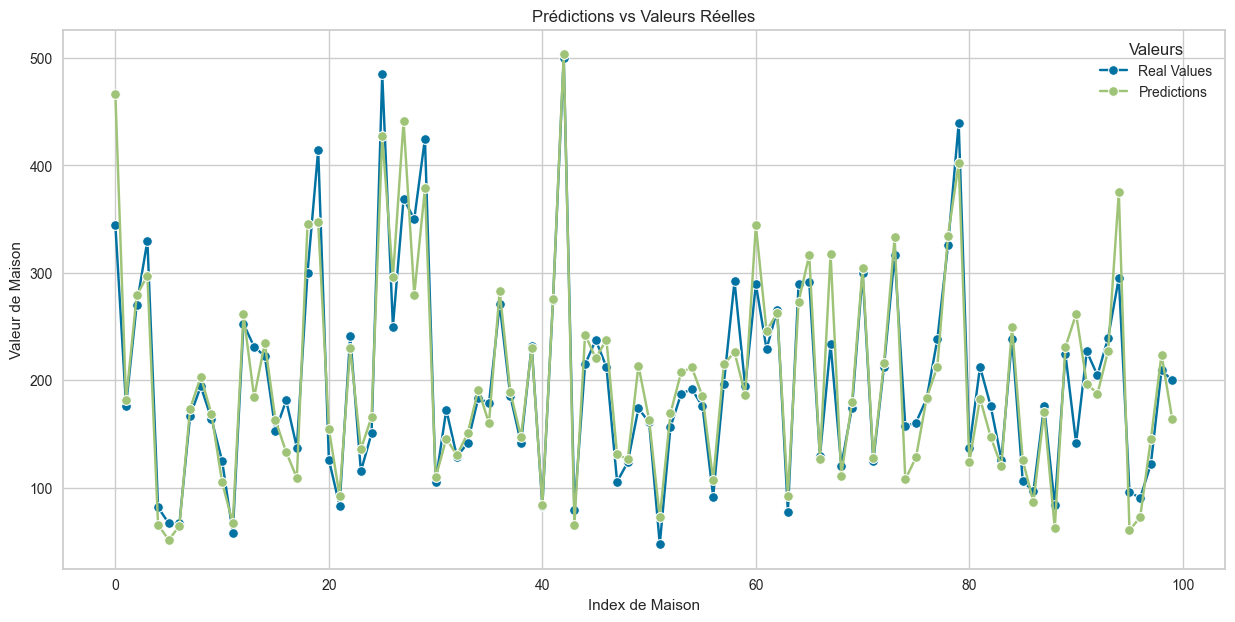

In [35]:
# Prendre les 100 premières lignes (maisons)
results = results.iloc[:100,:]

# Créer le graphique avec seaborn
plt.figure(figsize=(15, 7))
sns.lineplot(data=results, x=results.index, y='median_house_value', marker='o', label='Real Values')
sns.lineplot(data=results, x=results.index, y='prediction_label', marker='o', label='Predictions')

plt.title('Prédictions vs Valeurs Réelles')
plt.xlabel('Index de Maison')
plt.ylabel('Valeur de Maison')
plt.legend(title='Valeurs')
plt.show()

## **Question 15 : Votre analyse d'usage de modèles ML pour la prédiction de prix de maisons**

##############################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################